In [1]:
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np

from scipy.special import gamma
from scipy.integrate import quad
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

import snowScatt
from pytmatrix import tmatrix, tmatrix_aux, scatter, radar, refractive

from __prepare_hydrometeors import get_cloud_dsd, get_rain_dsd
from __prepare_hydrometeors import generate_rain_lookuptable
from __prepare_hydrometeors import get_rime_fraction_index # puts rime fraction into 0(<0 to 0.25) 1(0.25<=x<0.5) 2(0.5<=x<0.75) 3(0.75<x)
from __prepare_hydrometeors import get_rime_density_index # as before but 5 categories, plus it caps rime density
from __prepare_hydrometeors import calc_bulkRhoRime
from __prepare_hydrometeors import calc_threshold # my version vectorizable
from __prepare_hydrometeors import q2abs

import warnings
warnings.simplefilter("ignore")
import time
import sys
# Different types of files:
# 2d_cldprcp (ncells, vertices, time), # 2d_cldprcp (ncells, vertices, time) -> 2d fields, strange dimensions
# basic__ (time, lon, lat, height) -> this seems the interesting one
# basic_zlev(time, lon, lat, alt) -> altitude? 93 alts instead of 150 heights???
# hlev_int50m_basic__ (time, lon, lat, height) -> again 93
iconP3path = '/data/optimice/P3paper_ICONoutput/P3realcase__20151124_624m_satad0/hlev_int50m_basic__DOM01_ML_20151124T1*Z.nc'
iconP3files = sorted(glob(iconP3path))

# Keep only the important variables
drops = ['u', 'v', 'w',
         #'temp',
         't_g', 'u_10m', 'v_10m',
         'qv', 'clc',
         #'qc', 'qi', 'qr', 'qirim', 'birim', 'qnc', 'qnr', 'qni',
         #'p3eqv_refl', # keeping for comparison purposes
         'p3reff_cld', 'p3reff_ice', 'p3mw_vi', 'p3dmean_ice', 
         #'p3rho_ice', # see if I can make use of it
         'p3ncnuc', 'p3qcnuc', 'p3ncheti', 'p3qcheti', 'p3nrheti', 'p3qrheti', 'p3ninuc', 'p3qinuc',
         'qccondiag', 'qrcondiag', 'dep_rate_ice', 'aggr_ice_n', 't_cbase', 'p_cbase', 't_ctop', 'p_ctop',
         #'rh',
         'temp_old',
         #'pres',
         # 'lamc', 'lamr', 'lami', 'mu_c', 'mu_r' # these Markus calculate himself, why?
        ]
# markusToKeep=["temp","pres","rh","qc","qi","qr","qnc","qni","qnr","qirim","birim"]

# Preprocessing of the data
def generate_preprocess(): # can take arguments
    # Generate a preprocess function that takes a dataset as only argument and does all the processing needed
    def preprocess(ds):
        # Convert strage YMD.fraction_of_the_day format into datetime64 (loss precision not important)
        ds['time'] = pd.to_datetime(ds.time.values.astype(int).astype(str), format='%Y%m%d') + pd.to_timedelta(ds.time.values%1, unit='D').round('1s')
        return ds
    return preprocess
iconP3data = xr.open_mfdataset(iconP3files,
                               concat_dim='time',
                               data_vars='minimal',
                               preprocess=generate_preprocess(), # drop_variables is called first
                               drop_variables=drops
                              ).isel(lat=0, lon=0).squeeze()
datetime = iconP3data.time.values
height = iconP3data.height.values

# To convert from specific to absolute quantities (take out hydrometeor occupied volume from the calculation of air density)
air_density = q2abs(1.0, iconP3data.temp, iconP3data.pres, iconP3data.rh, iconP3data.qc+iconP3data.qr+iconP3data.qi)

In [2]:
#%%timeit
# Compute DSDs parameters my self...
start = time.time()
generate_rain_lookuptable() #generate rain lookup-table at beginning 
mu_r_table = np.load('mu_r_table.npz') #just read the lookup-table
mu_r_table = mu_r_table['mu_r_table']
vector_cloud_dsd = np.vectorize(get_cloud_dsd, otypes=[np.float, np.float])
mu_c, lamc = vector_cloud_dsd(iconP3data.qc, iconP3data.qnc, iconP3data.pres, iconP3data.temp)
vector_rain_dsd = np.vectorize(get_rain_dsd, otypes=[np.float, np.float], excluded=['mu_r_table'])
mu_r, lamr = vector_rain_dsd(iconP3data.qr, iconP3data.qnr, iconP3data.pres, iconP3data.temp, mu_r_table=mu_r_table)
time.time()-start

4.520131826400757

In [3]:
# Calculate ice properties
start = time.time()
qi_tot = iconP3data.qi + iconP3data.qirim
rime_fraction = iconP3data.qirim/qi_tot.fillna(0.0)
vector_rime_fraction_index = np.vectorize(get_rime_fraction_index)
rime_frac_idx = vector_rime_fraction_index(rime_fraction.fillna(0.0))
vector_bulkRhoRime = np.vectorize(calc_bulkRhoRime)
rime_density = vector_bulkRhoRime(iconP3data.qirim, iconP3data.birim)
vector_rime_density_index = np.vectorize(get_rime_density_index)
rime_density, rime_dens_idx = vector_rime_density_index(rime_density)
vector_ice_PSD = np.vectorize(calc_threshold)
PSD = vector_ice_PSD(rime_dens_idx, rime_frac_idx, iconP3data.qni.fillna(0.0), qi_tot.fillna(0.0), rime_fraction.fillna(0.0), rime_density) # This executes for the whole day in 10 minutes. I guess I can speed up if I find a way to not load the vectors in memory
n_tot, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, _, _, _, _, _, _ = PSD
time.time()-start # ~ 10 minutes

297.7238941192627

In [4]:
Dice = np.logspace(-6, -1.1, 100) # limit for W band refl
Dcloud = np.logspace(-12, -4, 100)
Drain = np.logspace(-6, -2, 100)

def gammaPSD(N0, mu, lam):
    def N(D):
        return N0*D**mu*np.exp(-lam*D)
    return N

def iceP3mass(dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr):
    functions = [lambda x: np.nan,
                 lambda x: cs1*x**ds1,
                 lambda x: cs*x**ds,
                 lambda x: cgp*x**dg,
                 lambda x: csr*x**dsr]
    def mass(D):
        conditions = [D<=0.0,
                      (0.0<D)*(D<=dcrit),
                      (dcrit<D)*(D<=dcrits),
                      (dcrits<D)*(D<=dcritr),
                      dcritr<D]
        return np.piecewise(D, conditions, functions)
    return mass


#def iceP3density(dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr):
#    functions = [lambda x: np.nan,
#                 lambda x: (cs1*x**ds1)/(np.pi*x**3/6.0),
#                 lambda x: (cs*x**ds)/(np.pi*0.1*x**3),
#                 lambda x: (cgp*x**dg)/(np.pi*x**3/6.0),
#                 lambda x: (csr*x**dsr)/(np.pi*0.1*x**3)] # I can perhaps simplify?
#    def density(D):
#        conditions = [D<=0.0,
#                      (0.0<D)*(D<=dcrit),
#                      (dcrit<D)*(D<=dcrits),
#                      (dcrits<D)*(D<=dcritr),
#                      dcritr<D]
#        return np.piecewise(D, conditions, functions)
#    return density


def iceP3aspect(dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr):
    functions = [lambda x: np.nan,
                 lambda x: 1.0,
                 lambda x: 0.6,
                 lambda x: 1.0,
                 lambda x: 0.6] # I can perhaps simplify?
    def aspect(D):
        conditions = [D<=0.0,
                      (0.0<D)*(D<=dcrit),
                      (dcrit<D)*(D<=dcrits),
                      (dcrits<D)*(D<=dcritr),
                      dcritr<D]
        return np.piecewise(D, conditions, functions)
    return aspect


def calc_q(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
    N = gammaPSD(N0, mu, lam)
    mass = iceP3mass(dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr)
    return (N(D)*mass(D)*np.gradient(D)).sum()
vector_q = np.vectorize(calc_q, excluded=['D'], otypes=[np.float])

def calc_N(N0, mu, lam, D):
    N = gammaPSD(N0, mu, lam)
    return (N(D)*np.gradient(D)).sum()
vector_N = np.vectorize(calc_N, excluded=['D'], otypes=[np.float])

#################################################################################
# SCATTERING PART
#################################################################################
freq_str = 'W'
wl = tmatrix_aux.wl_W
n_water = refractive.m_w_0C[wl]
rayleigh_coeff = wl**4/(tmatrix_aux.K_w_sqr[wl]*np.pi**5)
wl *= 1.0e-3 # back to meters

def tm_reflectivity(size, wl, n, ar=1.0):
    scatt = tmatrix.Scatterer(radius=0.5e3*size, # conversion to millimeter radius
                              wavelength=wl*1.0e3, # conversion to millimeters
                              m=n,
                              axis_ratio=1.0/ar)
    scatt.set_geometry(tmatrix_aux.geom_vert_back)
    return radar.radar_xsect(scatt) # mm**2 ... need to integrate and multiply by Rayleigh factor

scat_cloud = np.empty_like(Dcloud)
for i, d in enumerate(Dcloud):
    scat_cloud[i] = tm_reflectivity(d, wl, n_water)
scat_rain = np.empty_like(Drain)
for i, d in enumerate(Drain):
    scat_rain[i] = tm_reflectivity(d, wl, n_water)

def calc_liquid_Z(N0, mu, lam, D, z):
    N = gammaPSD(N0, mu, lam)
    return (N(D)*z*np.gradient(D)).sum()
vector_liquid_Z = np.vectorize(calc_liquid_Z, excluded=['D', 'z'], otypes=[np.float])

z_tm_precomputed = pd.DataFrame(index=Dice, columns=['solid', 'BF95'])
for i in Dice:
    z_tm_precomputed.loc[i, 'solid'] = tm_reflectivity(i, wl, refractive.mi(wl*1.0e3, 0.900), 1.0)
    z_tm_precomputed.loc[i, 'BF95'] = tm_reflectivity(i, wl, refractive.mi(wl*1.0e3, 1.0e-3*0.0121*6.0*i**(-1.1)/(np.pi*0.6)), 0.6)

a_graupel = np.linspace(21, 472, 1000)
a_partrimed = np.linspace(0.0121, 0.024, 1000)
#z_tm_graupel = pd.DataFrame(index=a_graupel, columns=Dice)
#z_tm_partrimed = pd.DataFrame(index=a_partrimed, columns=Dice)
start = time.time()
z_tm_graupel = pd.read_csv('z_tm_graupel_'+freq_str+'.csv', index_col=0, dtype=np.float64, engine='c')
z_tm_graupel.columns = z_tm_graupel.columns.astype(np.float)
z_tm_partrimed = pd.read_csv('z_tm_partrimed_'+freq_str+'.csv', index_col=0, dtype=np.float64, engine='c')
z_tm_partrimed.columns = z_tm_partrimed.columns.astype(np.float)
#for i in Dice:
#    for j in a_graupel:
#        z_tm_graupel.loc[j, i] = tm_reflectivity(i, wl, refractive.mi(wl*1.0e3, 1.0e-3*j*6.0/np.pi))
#for i in Dice:
#    for j in a_partrimed:
#        z_tm_partrimed.loc[j, i] = tm_reflectivity(i, wl, refractive.mi(wl*1.0e3, 1.0e-3*j*6.0*i**(-1.1)/np.pi))
print(time.time() - start )

def iceP3tm_backscattering(dcrit, dcrits, dcritr):
    functions = [lambda x, ag, apr: np.nan,
                 lambda x, ag, apr: z_tm_precomputed.loc[x, 'solid'],
                 lambda x, ag, apr: z_tm_precomputed.loc[x, 'BF95'],
                 lambda x, ag, apr: z_tm_graupel.iloc[z_tm_graupel.index.get_loc(ag, 'nearest')].loc[x],
                 lambda x, ag, apr: z_tm_partrimed.iloc[z_tm_partrimed.index.get_loc(apr, 'nearest')].loc[x]
                ]
    def backscattering(D, ag, apr):
        conditions = [D<=0.0,
                      (0.0<D)*(D<=dcrit),
                      (dcrit<D)*(D<=dcrits),
                      (dcrits<D)*(D<=dcritr),
                      dcritr<D
                     ]
        return np.piecewise(D, conditions, functions, ag, apr)
    return backscattering

def calc_ice_Z_tm(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
    N = gammaPSD(N0, mu, lam)
    #mass = iceP3mass(dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr)
    #aspect = iceP3aspect(dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr)
    #densities = 1.0e-3*mass(D)/(np.pi*aspect(D)*D**3/6.0) # 1.0e-3 to transform to g/cm3
    #ref = refractive.mi(wl*1.0e3, densities) # wl temporarly back to mm
    #z = np.zeros_like(D)
    backscattering = iceP3tm_backscattering(dcrit, dcrits, dcritr)
    #for i, (d, m, a) in enumerate(zip(D, ref, aspect(D))):
    #for i, d in enumerate(D):
        #if densities[i]:
            #print(d, m, a)
            #z[i] = tm_reflectivity(d, wl, m, a)
    #    z[i] = backscattering(d, cgp, csr)
    return (N(D)*backscattering(D, cgp, csr)*np.gradient(D)).sum()
vector_ice_Z_tm = np.vectorize(calc_ice_Z_tm, excluded=['D'], otypes=[np.float])

a_graupel = np.linspace(21, 472, 1000)
a_partrimed = np.linspace(0.0121, 0.024, 1000)
z_ssrga_partrimed = pd.DataFrame(index=a_partrimed, columns=Dice)
start = time.time()
z_ssrga_BF95 = pd.DataFrame(index=Dice, columns=['BF95'],
                            data=snowScatt.backscatter(Dice, wavelength=wl,
                                                       properties='Leinonen15tabA00', temperature=270.0,
                                                       mass=0.0121*Dice**1.9)*1.0e6 # convert to mm2
                           )
for j in a_partrimed:
    z_ssrga_partrimed.loc[j] = snowScatt.backscatter(Dice, wavelength=wl,
                                                     properties='Leinonen15tabA00', temperature=270.0,
                                                     mass=j*Dice**1.9)*1.0e6 # pass from m2 to mm2
print(time.time() - start )
def iceP3ssrga_backscattering(dcrit, dcrits, dcritr):
    functions = [lambda x, ag, apr: np.nan,
                 lambda x, ag, apr: z_tm_precomputed.loc[x, 'solid'],
                 lambda x, ag, apr: z_ssrga_BF95.loc[x, 'BF95'],
                 lambda x, ag, apr: z_tm_graupel.iloc[z_tm_graupel.index.get_loc(ag, 'nearest')].loc[x],
                 lambda x, ag, apr: z_ssrga_partrimed.iloc[z_ssrga_partrimed.index.get_loc(apr, 'nearest')].loc[x],
                ]
    def backscattering(D, ag, apr):
        conditions = [D<=0.0,
                      (0.0<D)*(D<=dcrit),
                      (dcrit<D)*(D<=dcrits),
                      (dcrits<D)*(D<=dcritr),
                      dcritr<D
                     ]
        return np.piecewise(D, conditions, functions, ag, apr)
    return backscattering

def calc_ice_Z_ssrga(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
    N = gammaPSD(N0, mu, lam)
    backscattering = iceP3ssrga_backscattering(dcrit, dcrits, dcritr)
    return (N(D)*backscattering(D, cgp, csr)*np.gradient(D)).sum()
vector_ice_Z_ssrga = np.vectorize(calc_ice_Z_ssrga, excluded=['D'], otypes=[np.float])



0.033550262451171875
11.765876770019531


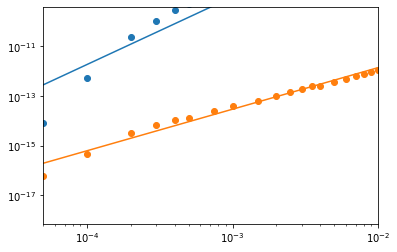

In [5]:
#wl = tmatrix_aux.wl_X*1.0e-3
RHfile = '/home/dori/develop/scatdb/share/scatdb.csv'
dataRH = pd.read_csv(RHfile)
dataRH = dataRH[dataRH.flaketype == 9] # sector snowflake
#dataRH = dataRH[dataRH.flaketype == 20] # aggregate spherical
#dataRH = dataRH[dataRH.flaketype == 21] # aggregate oblate
#dataRH = dataRH[dataRH.flaketype == 22] # aggregate prolate
dataRH = dataRH[abs(dataRH.temperaturek-270) < 4.9]
dataRH = dataRH[abs(dataRH.frequencyghz-1.0e-9*snowScatt._compute._c/wl) < 0.5]
dataRH['max_dimension'] = dataRH.max_dimension_mm*1.0e-3
dataRH.set_index('max_dimension', inplace=True)
dataRH.sort_index(inplace=True)
dataRH['aeff'] = dataRH.aeffum*1.0e-6
dataRH['mass'] = 4.0*np.pi*900.0*dataRH.aeff**3/3
#dataRH['xeff'] = dataRH.aeff*2.0*np.pi*dataRH.frequencyghz*1.0e9/snowScatt._compute._c
#dataRH['Qs'] = dataRH.csca/(np.pi*dataRH.aeff**2)
#dataRH['Qb'] = dataRH.cbk/(np.pi*dataRH.aeff**2)
bm, am = np.polyfit(x=np.log10(dataRH.index.values.astype(np.float)),
                    y=np.log10(dataRH.mass.values.astype(np.float)),
		            deg=1)
am = 10.0**am
bc, ac = np.polyfit(x=np.log10(dataRH.index.values.astype(np.float)),
                    y=np.log10(dataRH.cbk.values.astype(np.float)),
		            deg=1)
ac = 10.0**ac
def dda_scattering(d):
    return am*d**bm, ac*d**bc

mass_fit, bck_fit = dda_scattering(dataRH.index)
plt.scatter(dataRH.index, dataRH.cbk)
plt.scatter(dataRH.index, dataRH.mass*1.0e-6)
plt.plot(dataRH.index, bck_fit)
plt.plot(dataRH.index, mass_fit*1e-6)
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.00005, 0.01])
plt.ylim([7e-19, 4e-10])

def z_dda(d, m):
    mdda, bck = dda_scattering(d)
    return bck*1.0e6*(m/mdda)**2# convert to mm2 #*(m/mdda)**2

def iceP3dda_backscattering(dcrit, dcrits, dcritr):
    functions = [lambda x, ag, apr: np.nan,
                 lambda x, ag, apr: z_tm_precomputed.loc[x, 'solid'],
                 lambda x, ag, apr: z_dda(x, 0.0121*x**1.9),
                 lambda x, ag, apr: z_tm_graupel.iloc[z_tm_graupel.index.get_loc(ag, 'nearest')].loc[x],
                 lambda x, ag, apr: z_dda(x, apr*x**1.9),
                ]
    def backscattering(D, ag, apr):
        conditions = [D<=0.0,
                      (0.0<D)*(D<=dcrit),
                      (dcrit<D)*(D<=dcrits),
                      (dcrits<D)*(D<=dcritr),
                      dcritr<D
                     ]
        return np.piecewise(D, conditions, functions, ag, apr)
    return backscattering

def calc_ice_Z_dda(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
    N = gammaPSD(N0, mu, lam)
    backscattering = iceP3dda_backscattering(dcrit, dcrits, dcritr)
    return (N(D)*backscattering(D, cgp, csr)*np.gradient(D)).sum()
vector_ice_Z_dda = np.vectorize(calc_ice_Z_dda, excluded=['D'], otypes=[np.float])

In [6]:
# Calculate intercept parameters for all DSDs and PSDs
N0i = n_tot*lami**(mui+1.)/gamma(mui+1.)*air_density
N0c = iconP3data.qnc*lamc**(mu_c+1.)/gamma(mu_c+1.)*air_density
N0r = iconP3data.qnr*lamr**(mu_r+1.)/gamma(mu_r+1.)*air_density

233057 232829 1 2
0.023946692445185505
21.58645984172
[6.06420708e-01 6.06420708e-01 1.00000000e+06]


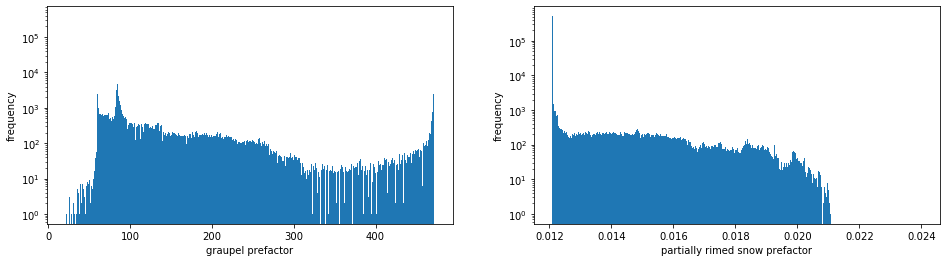

In [7]:
print(len(np.unique(cgp[np.nonzero(cgp)])),
      len(np.unique(csr[np.nonzero(csr)])),
      len(np.unique(dg[np.nonzero(dg)])),
      len(np.unique(dsr[np.nonzero(dsr)]))
     )
print(np.nanmax(csr[(csr>0.013)*(csr<23)]))
print(np.nanmin(cgp[(cgp>0.0)]))
print(dcritr[csr>20])
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
a = axs[0].hist(cgp[(cgp>0)].flatten(), bins=np.linspace(21, 472, 1000))
b = axs[1].hist(csr[(csr>0)*(csr>0.012)*(csr<10)].flatten(), bins=np.linspace(0.0121, 0.024, 1000))
axs[0].set_yscale('log')
axs[0].set_xlabel('graupel prefactor')
axs[0].set_ylabel('frequency')
axs[1].set_yscale('log')
axs[1].set_xlabel('partially rimed snow prefactor')
axs[1].set_ylabel('frequency')
fig.savefig('prefactor_frequency.png')


In [8]:
Zcloud = vector_liquid_Z(N0c.values, mu_c, lamc, D=Dcloud, z=scat_cloud)
Zrain = vector_liquid_Z(N0r.values, mu_r, lamr, D=Drain, z=scat_rain)
start = time.time()
ZiceTM = vector_ice_Z_tm(N0i.values, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D=Dice)
print(time.time()-start) # less than 2 minutes for the liquid part, 

592.4240193367004


In [9]:
start = time.time()
ZiceSSRGA = vector_ice_Z_ssrga(N0i.values, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D=Dice)
print(time.time()-start)

599.9675526618958


In [10]:
start = time.time()
ZiceDDA = vector_ice_Z_dda(N0i.values, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D=Dice)
print(time.time()-start)

263.57265639305115


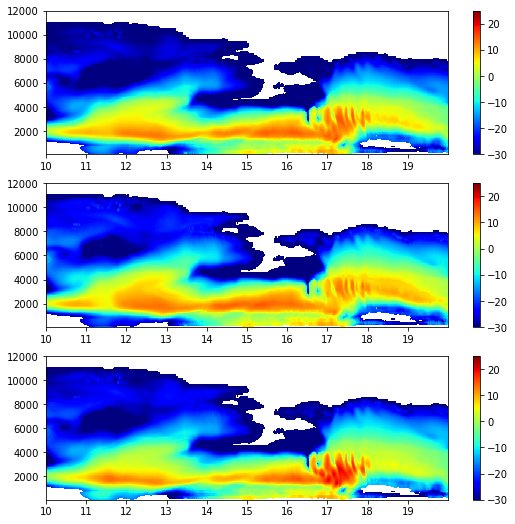

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(9, 9))
#mesh = axs[0].pcolormesh(datetime, height, iconP3data.p3eqv_refl.T, vmin=-30, vmax=25, cmap='jet')
mesh = axs[0].pcolormesh(datetime, height, 10.0*np.log10(rayleigh_coeff*(Zrain.T+Zcloud.T+ZiceSSRGA.T)), vmin=-30, vmax=25, cmap='jet')
plt.colorbar(mesh, ax=axs[0])
mesh = axs[1].pcolormesh(datetime, height, 10.0*np.log10(rayleigh_coeff*(Zrain.T+Zcloud.T+ZiceTM.T)), vmin=-30, vmax=25, cmap='jet')
plt.colorbar(mesh, ax=axs[1])
mesh = axs[2].pcolormesh(datetime, height, 10.0*np.log10(rayleigh_coeff*(Zrain.T+Zcloud.T+ZiceDDA.T)), vmin=-30, vmax=25, cmap='jet')
plt.colorbar(mesh, ax=axs[2])
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
fig.savefig('SSRGA_TM_Liu_'+freq_str+'.png')

In [18]:
ZssrgaW = 10.0*np.log10(rayleigh_coeff*(Zrain.T+Zcloud.T+ZiceSSRGA.T))
ZtmW = 10.0*np.log10(rayleigh_coeff*(Zrain.T+Zcloud.T+ZiceTM.T))
ZddaW = 10.0*np.log10(rayleigh_coeff*(Zrain.T+Zcloud.T+ZiceDDA.T))
np.savetxt('ZssrgaW.txt', ZssrgaW)
np.savetxt('ZtmW.txt', ZtmW)
np.savetxt('ZddaW.txt', ZddaW)

In [13]:
am

0.0030793099360226428

In [14]:
start = time.time()
func_map = map(iceP3mass, dcrit.flatten(), dcrits.flatten(), dcritr.flatten(), cs1.flatten(), ds1.flatten(), cs.flatten(), ds.flatten(), cgp.flatten(), dg.flatten(), csr.flatten(), dsr.flatten())
func_list = list(func_map)
mass_lists = [f(Dice) for f in func_list if f(Dice).sum()>0.0]
mass_stack = np.empty((len(mass_lists), len(mass_lists[0]))) 
#D_stack = np.empty_like(mass_stack)
for i, m in enumerate(mass_lists):
    mass_stack[i, :] = m
    #D_stack[i, :] = D
print(time.time()-start) # ~ 2 minutes

59.603548765182495


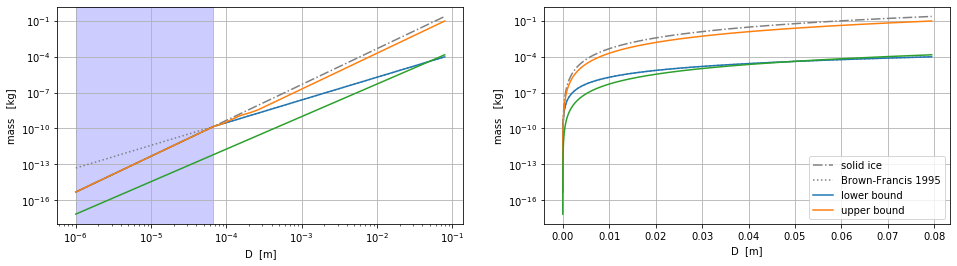

In [15]:
lower_bound = np.nanmin(mass_stack, axis=0)
upper_bound = np.nanmax(mass_stack, axis=0)
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
for i in axs:
    i.plot(Dice, 471.23889804*Dice**3.0, c='grey', ls='-.', label='solid ice')
    i.plot(Dice, 0.0121*Dice**1.9, c='grey', ls=':', label='Brown-Francis 1995')
    i.plot(Dice, lower_bound, label='lower bound')
    i.plot(Dice, upper_bound, label='upper bound')
    i.plot(Dice, dda_scattering(Dice)[1])
    i.set_yscale('log')
    i.grid()
    i.set_xlabel('D  [m]')
    i.set_ylabel('mass   [kg]')
axs[1].legend(loc=4)
axs[0].axvspan(Dice[0], np.nanmax(dcrit), color='blue', alpha=0.2, label='spherical ice ')
axs[0].set_xscale('log')
fig.savefig('mass_size_limits.png')

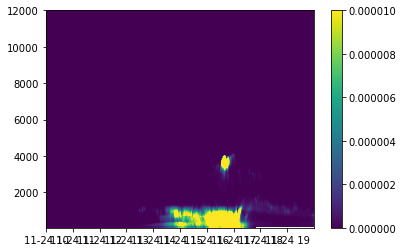

In [16]:
#mesh = plt.pcolormesh(datetime, height, iconP3data.p3rho_ice.T)
#mesh = plt.pcolormesh(datetime, height, rime_dens_idx.T)
#mesh = plt.pcolormesh(datetime, height, rime_frac_idx.T)
#mesh = plt.pcolormesh(datetime, height, qi_tot.T, vmax=0.0003)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qnc.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qnr.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qni.T, vmax= 350000)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qc.T)
mesh = plt.pcolormesh(datetime, height, iconP3data.qr.T, vmax=0.00001)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qi.T, vmax=0.0002)
#mesh = plt.pcolormesh(datetime, height, rime_density.T)
#mesh = plt.pcolormesh(datetime, height, air_density.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.rh.T)
plt.colorbar(mesh)

In [17]:
#plt.pcolormesh(datetime, height, iconP3data.temp.T)
#plt.pcolormesh(datetime, height, iconP3data.p3eqv_refl.T)
#mesh = plt.pcolormesh(datetime, height, rime_density.T)
#mesh = plt.pcolormesh(datetime, height, n_tot.T)
#mesh = plt.pcolormesh(datetime, height, qc.T)
mesh = plt.pcolormesh(datetime, height, qr.T, vmax=0.00001)
#mesh = plt.pcolormesh(datetime, height, qi.T, vmax=0.0002)
#mesh = plt.pcolormesh(datetime, height, Ni.T, vmax=350000)
#mesh = plt.pcolormesh(datetime, height, Nc.T)
#mesh = plt.pcolormesh(datetime, height, Nr.T)
plt.colorbar(mesh)

NameError: name 'qr' is not defined

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
axs[0, 0].scatter(iconP3data.qc.values.flatten(), qc.flatten())
qc_lim=[0.0, 0.8e-3]; axs[0, 0].set_xlim(qc_lim); axs[0, 0].set_ylim(qc_lim); axs[0, 0].plot(qc_lim, qc_lim, 'r')
axs[1, 0].scatter(iconP3data.qr.values.flatten(), qr.flatten())
qr_lim=[0.0, 1.3e-4]; axs[1, 0].set_xlim(qr_lim); axs[1, 0].set_ylim(qr_lim); axs[1, 0].plot(qr_lim, qr_lim, 'r')
#axs[2, 0].scatter(iconP3data.qi.values.flatten(), qi.flatten())
axs[2, 0].scatter(qi_tot.values.flatten(), qi.flatten())
qi_lim=[0.0, 1e-3]; axs[2, 0].set_xlim(qi_lim); axs[2, 0].set_ylim(qi_lim); axs[2, 0].plot(qi_lim, qi_lim, 'r')

axs[0, 1].scatter(iconP3data.qnc.values.flatten(), Nc.flatten())
Nc_lim=[0.0, 1.25e9]; axs[0, 1].set_xlim(Nc_lim); axs[0, 1].set_ylim(Nc_lim); axs[0, 1].plot(Nc_lim, Nc_lim, 'r')
axs[1, 1].scatter(iconP3data.qnr.values.flatten(), Nr.flatten())
Nr_lim=[0.0, 8.0e4]; axs[1, 1].set_xlim(Nr_lim); axs[1, 1].set_ylim(Nr_lim); axs[1, 1].plot(Nr_lim, Nr_lim, 'r')
axs[2, 1].scatter(iconP3data.qni.values.flatten(), Ni.flatten())
Ni_lim=[0.0, 7.0e5]; axs[2, 1].set_xlim(Ni_lim); axs[2, 1].set_ylim(Ni_lim); axs[2, 1].plot(Ni_lim, Ni_lim, 'r') 
axs[0, 0].set_xlabel('P3 qc'); axs[0, 0].set_ylabel('integrated qc')
axs[1, 0].set_xlabel('P3 qr'); axs[1, 0].set_ylabel('integrated qr')
axs[2, 0].set_xlabel('P3 qi+qirim'); axs[2, 0].set_ylabel('integrated qi')
axs[0, 1].set_xlabel('P3 qnc'); axs[0, 1].set_ylabel('integrated Nc')
axs[1, 1].set_xlabel('P3 qnr'); axs[1, 1].set_ylabel('integrated Nr')
axs[2, 1].set_xlabel('P3 qni'); axs[2, 1].set_ylabel('integrated Ni')
fig.tight_layout()
fig.savefig('scatter_P3_computed.png')

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
#xy = np.vstack([iconP3data.qc.values.flatten(), qc.flatten()]); z = gaussian_kde(xy)(xy)
#idx = z.argsort(); x, y, z = x[idx], y[idx], z[idx]
#axs[0, 0].scatter(x, y, c=z, s=50, edgecolor='')
mesh = axs[0, 0].hexbin(iconP3data.qc.values.flatten(), qc.flatten(), bins='log', cmap='BuGn', gridsize=20)
plt.colorbar(mesh, ax=axs[0, 0])
qc_lim=[0.0, 0.8e-3]; axs[0, 0].set_xlim(qc_lim); axs[0, 0].set_ylim(qc_lim); axs[0, 0].plot(qc_lim, qc_lim, 'r')
mesh = axs[1, 0].hexbin(iconP3data.qr.values.flatten(), qr.flatten(), bins='log', cmap='BuGn', gridsize=20)
plt.colorbar(mesh, ax=axs[1, 0])
qr_lim=[0.0, 1.3e-4]; axs[1, 0].set_xlim(qr_lim); axs[1, 0].set_ylim(qr_lim); axs[1, 0].plot(qr_lim, qr_lim, 'r')
#axs[2, 0].scatter(iconP3data.qi.values.flatten(), qi.flatten())
mesh = axs[2, 0].hexbin(qi_tot.values.flatten(), qi.flatten(), bins='log', cmap='BuGn', gridsize=20)
plt.colorbar(mesh, ax=axs[2, 0])
qi_lim=[0.0, 1e-3]; axs[2, 0].set_xlim(qi_lim); axs[2, 0].set_ylim(qi_lim); axs[2, 0].plot(qi_lim, qi_lim, 'r')

mesh = axs[0, 1].hexbin(iconP3data.qnc.values.flatten(), Nc.flatten(), bins='log', cmap='BuGn', gridsize=20)
plt.colorbar(mesh, ax=axs[0, 1])
Nc_lim=[0.0, 1.25e9]; axs[0, 1].set_xlim(Nc_lim); axs[0, 1].set_ylim(Nc_lim); axs[0, 1].plot(Nc_lim, Nc_lim, 'r')
mesh = axs[1, 1].hexbin(iconP3data.qnr.values.flatten(), Nr.flatten(), bins='log', cmap='BuGn', gridsize=20)
plt.colorbar(mesh, ax=axs[1, 1])
Nr_lim=[0.0, 8.0e4]; axs[1, 1].set_xlim(Nr_lim); axs[1, 1].set_ylim(Nr_lim); axs[1, 1].plot(Nr_lim, Nr_lim, 'r')
mesh = axs[2, 1].hexbin(iconP3data.qni.values.flatten(), Ni.flatten(), bins='log', cmap='BuGn', gridsize=20)
plt.colorbar(mesh, ax=axs[2, 1])
Ni_lim=[0.0, 7.0e5]; axs[2, 1].set_xlim(Ni_lim); axs[2, 1].set_ylim(Ni_lim); axs[2, 1].plot(Ni_lim, Ni_lim, 'r') 
axs[0, 0].set_xlabel('P3 qc'); axs[0, 0].set_ylabel('integrated qc')
axs[1, 0].set_xlabel('P3 qr'); axs[1, 0].set_ylabel('integrated qr')
axs[2, 0].set_xlabel('P3 qi+qirim'); axs[2, 0].set_ylabel('integrated qi')
axs[0, 1].set_xlabel('P3 qnc'); axs[0, 1].set_ylabel('integrated Nc')
axs[1, 1].set_xlabel('P3 qnr'); axs[1, 1].set_ylabel('integrated Nr')
axs[2, 1].set_xlabel('P3 qni'); axs[2, 1].set_ylabel('integrated Ni')
fig.tight_layout()
fig.savefig('density_P3_computed.png')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
mesh = axs[0, 0].pcolormesh(datetime, height, iconP3data.qnc.T, vmax=Nc_lim[1], norm=mcolors.LogNorm(1e6, Nc_lim[1]));
plt.colorbar(mesh, ax=axs[0, 0])
mesh = axs[0, 1].pcolormesh(datetime, height, Nc.T, vmax=Nc_lim[1], norm=mcolors.LogNorm(1e6, Nc_lim[1]));
plt.colorbar(mesh, ax=axs[0, 1])
mesh = axs[1, 0].pcolormesh(datetime, height, iconP3data.qc.T, vmax=qc_lim[1], norm=mcolors.LogNorm(1e-10, qc_lim[1]));
plt.colorbar(mesh, ax=axs[1, 0])
mesh = axs[1, 1].pcolormesh(datetime, height, qc.T, vmax=qc_lim[1], norm=mcolors.LogNorm(1e-10, qc_lim[1]));
plt.colorbar(mesh, ax=axs[1, 1])
axs[0,0].set_title('ICON P3');
axs[0,1].set_title('Integrated from PSD');
axs[0,0].set_ylabel('N cloud'); axs[1,0].set_ylabel('Q cloud');
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
fig.savefig('cloud_qN.png')


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
mesh = axs[0, 0].pcolormesh(datetime, height, iconP3data.qnr.T, vmax=Nr_lim[1], norm=mcolors.LogNorm(1, Nr_lim[1]));
plt.colorbar(mesh, ax=axs[0, 0])
mesh = axs[0, 1].pcolormesh(datetime, height, Nr.T, vmax=Nr_lim[1], norm=mcolors.LogNorm(1, Nr_lim[1]));
plt.colorbar(mesh, ax=axs[0, 1])
mesh = axs[1, 0].pcolormesh(datetime, height, iconP3data.qr.T, vmax=qr_lim[1], norm=mcolors.LogNorm(1e-10, qr_lim[1]));
plt.colorbar(mesh, ax=axs[1, 0])
mesh = axs[1, 1].pcolormesh(datetime, height, qr.T, vmax=qr_lim[1], norm=mcolors.LogNorm(1e-10, qr_lim[1]));
plt.colorbar(mesh, ax=axs[1, 1])
axs[0,0].set_title('ICON P3');
axs[0,1].set_title('Integrated from PSD');
axs[0,0].set_ylabel('N rain');
axs[1,0].set_ylabel('Q rain');
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
fig.savefig('rain_qN.png')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
mesh = axs[0, 0].pcolormesh(datetime, height, iconP3data.qni.T, vmax=Ni_lim[1], norm=mcolors.LogNorm(1, Ni_lim[1]))
plt.colorbar(mesh, ax=axs[0, 0])
mesh = axs[0, 1].pcolormesh(datetime, height, Ni.T, vmax=Ni_lim[1], norm=mcolors.LogNorm(1, Ni_lim[1]));
plt.colorbar(mesh, ax=axs[0, 1])
mesh = axs[1, 0].pcolormesh(datetime, height, iconP3data.qi.T+iconP3data.qirim.T, vmax=qi_lim[1], norm=mcolors.LogNorm(1e-8, qi_lim[1]));
plt.colorbar(mesh, ax=axs[1, 0])
mesh = axs[1, 1].pcolormesh(datetime, height, qi.T, vmax=qi_lim[1], norm=mcolors.LogNorm(1e-8, qi_lim[1]));
plt.colorbar(mesh, ax=axs[1, 1])
axs[0,0].set_title('ICON P3');
axs[0,1].set_title('Integrated from PSD');
axs[0,0].set_ylabel('N ice');
axs[1,0].set_ylabel('Q ice + Q rime');
[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
fig.savefig('ice_qN.png')

In [ ]:
z_tm_precomputed['BF95']
    

In [ ]:
z_tm_partrimed.iloc[z_tm_partrimed.index.get_loc(0.0121, 'nearest')]